In [20]:
# notebooks/02_anomaly_detection_models.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
df = pd.read_csv("../data/simulated_sensor_data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [3]:
# Features for anomaly detection
features = ['temperature', 'pressure']
X = df[features]
y_true = df['anomaly'] # True labels for evaluation

In [4]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

In [5]:
# --- Isolation Forest ---
print("--- Isolation Forest ---")

--- Isolation Forest ---


In [6]:
# Isolation Forest is sensitive to the contamination parameter (proportion of outliers in the data set)
# We can estimate it from our data's anomaly count
contamination_if = y_true.value_counts(normalize=True).get(1.0, 0) # Get proportion of anomalies
if contamination_if == 0: # If no anomalies in simulated data, set a small value
    contamination_if = 0.01

iso_forest = IsolationForest(random_state=42, contamination=contamination_if)
iso_forest.fit(X_scaled)

,n_estimators,100
,max_samples,'auto'
,contamination,np.float64(0.05)
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [7]:
# Predict anomalies (-1 for outliers, 1 for inliers)
# Convert -1 to 1 (anomaly) and 1 to 0 (normal) for consistency with y_true
y_pred_iso_forest = np.where(iso_forest.predict(X_scaled) == -1, 1, 0)

In [8]:
# Evaluation for Isolation Forest
print("\nIsolation Forest Classification Report:")
print(classification_report(y_true, y_pred_iso_forest, target_names=['Normal', 'Anomaly']))


Isolation Forest Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       950
     Anomaly       1.00      1.00      1.00        50

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



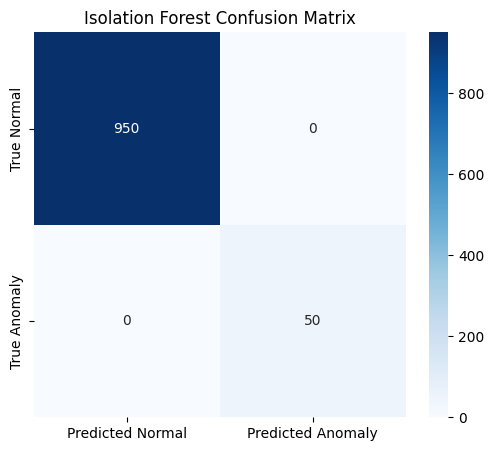

In [9]:
# Confusion Matrix
cm_iso_forest = confusion_matrix(y_true, y_pred_iso_forest)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_iso_forest, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.title('Isolation Forest Confusion Matrix')
plt.show()

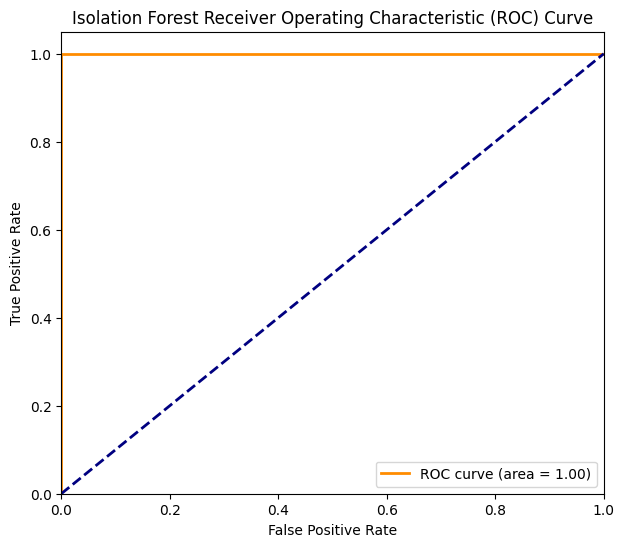

In [10]:
# ROC Curve
fpr_iso_forest, tpr_iso_forest, thresholds_iso_forest = roc_curve(y_true, iso_forest.decision_function(X_scaled) * -1) # Higher decision_function for anomalies
roc_auc_iso_forest = auc(fpr_iso_forest, tpr_iso_forest)

plt.figure(figsize=(7, 6))
plt.plot(fpr_iso_forest, tpr_iso_forest, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_iso_forest:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isolation Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

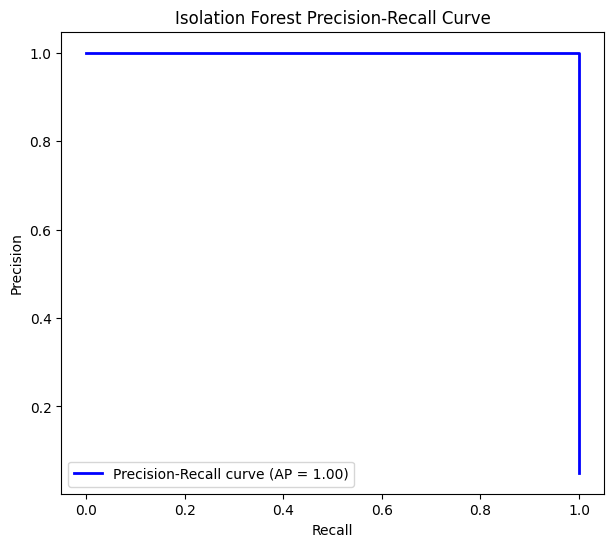

In [11]:
# Precision-Recall Curve
precision_iso_forest, recall_iso_forest, _ = precision_recall_curve(y_true, iso_forest.decision_function(X_scaled) * -1)
ap_iso_forest = average_precision_score(y_true, iso_forest.decision_function(X_scaled) * -1)

plt.figure(figsize=(7, 6))
plt.plot(recall_iso_forest, precision_iso_forest, color='blue', lw=2, label=f'Precision-Recall curve (AP = {ap_iso_forest:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Isolation Forest Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

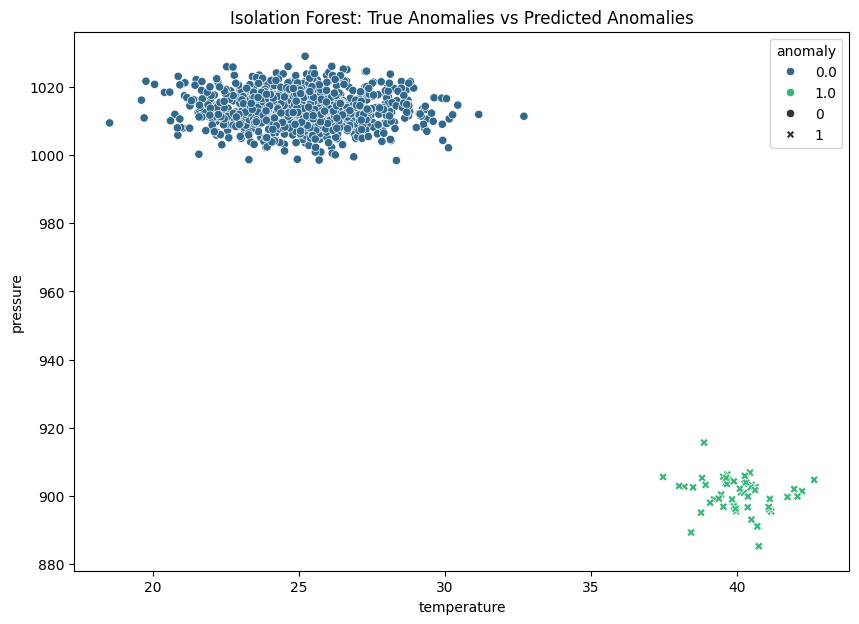

In [12]:
# Visualize anomalies detected by Isolation Forest
plt.figure(figsize=(10, 7))
sns.scatterplot(x='temperature', y='pressure', data=df, hue='anomaly', style=y_pred_iso_forest,
                palette='viridis', markers=['o', 'X']) # 'o' for normal, 'X' for predicted anomaly
plt.title('Isolation Forest: True Anomalies vs Predicted Anomalies')
plt.show()



In [13]:
# --- One-Class SVM ---
print("\n--- One-Class SVM ---")

# One-Class SVM is also sensitive to the nu parameter (an upper bound on the fraction of training errors
# and a lower bound of the fraction of support vectors)
# Often set to the expected contamination
nu_ocsvm = contamination_if # Using the same contamination estimate

oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=nu_ocsvm)
oc_svm.fit(X_scaled)


--- One-Class SVM ---


,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,tol,0.001
,nu,np.float64(0.05)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [14]:
# Predict anomalies (-1 for outliers, 1 for inliers)
y_pred_oc_svm = np.where(oc_svm.predict(X_scaled) == -1, 1, 0)

In [15]:
# Evaluation for One-Class SVM
print("\nOne-Class SVM Classification Report:")
print(classification_report(y_true, y_pred_oc_svm, target_names=['Normal', 'Anomaly']))


One-Class SVM Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96       950
     Anomaly       0.33      0.32      0.32        50

    accuracy                           0.93      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.93      0.93      0.93      1000



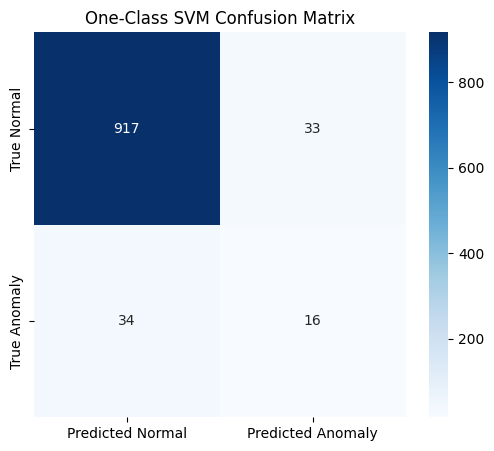

In [16]:
# Confusion Matrix
cm_oc_svm = confusion_matrix(y_true, y_pred_oc_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_oc_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.title('One-Class SVM Confusion Matrix')
plt.show()

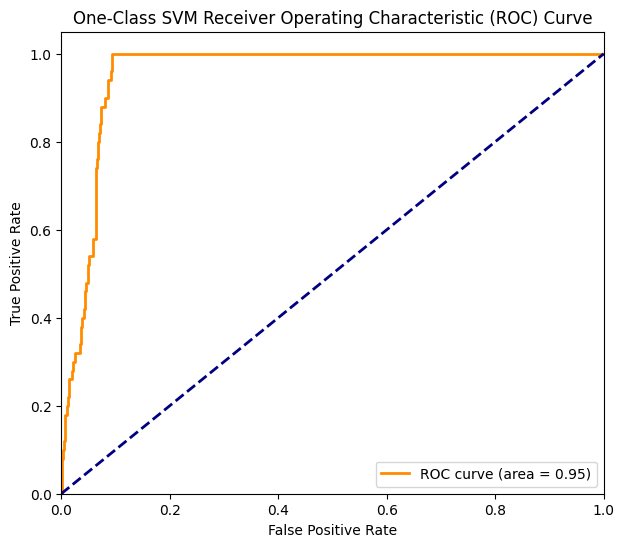

In [17]:
# ROC Curve
fpr_oc_svm, tpr_oc_svm, thresholds_oc_svm = roc_curve(y_true, oc_svm.decision_function(X_scaled) * -1)
roc_auc_oc_svm = auc(fpr_oc_svm, tpr_oc_svm)

plt.figure(figsize=(7, 6))
plt.plot(fpr_oc_svm, tpr_oc_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_oc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-Class SVM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

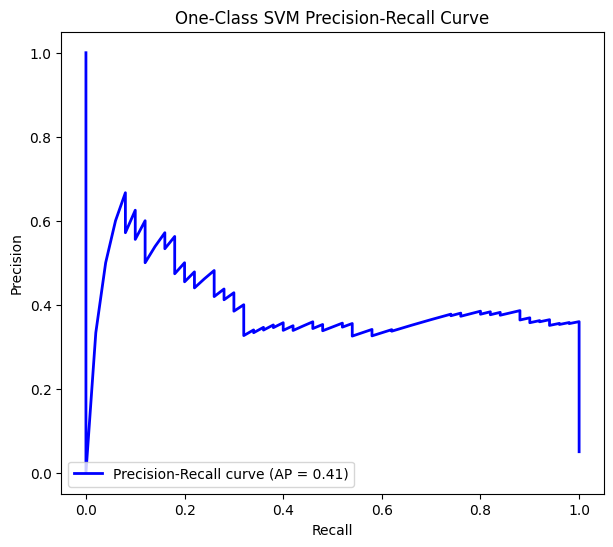

In [18]:
# Precision-Recall Curve
precision_oc_svm, recall_oc_svm, _ = precision_recall_curve(y_true, oc_svm.decision_function(X_scaled) * -1)
ap_oc_svm = average_precision_score(y_true, oc_svm.decision_function(X_scaled) * -1)

plt.figure(figsize=(7, 6))
plt.plot(recall_oc_svm, precision_oc_svm, color='blue', lw=2, label=f'Precision-Recall curve (AP = {ap_oc_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('One-Class SVM Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

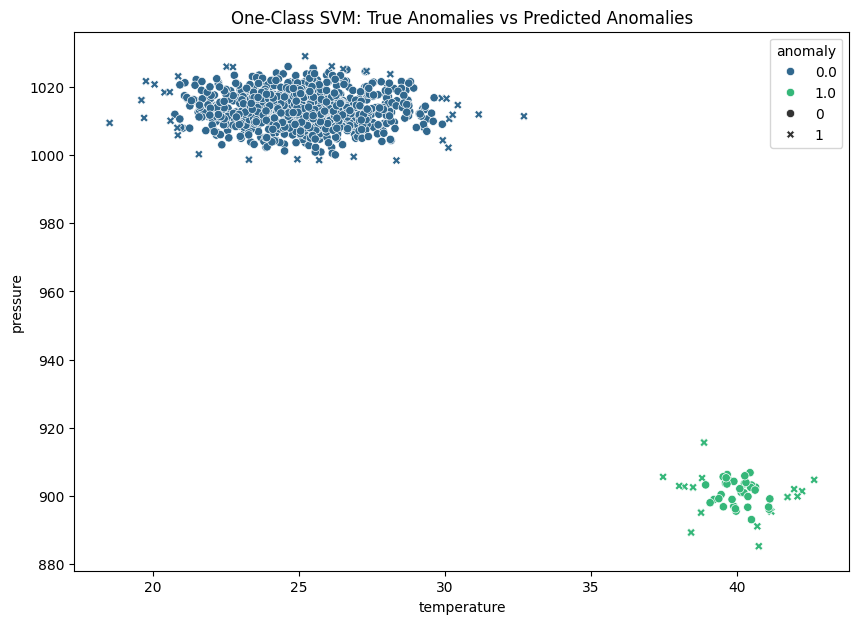


Anomaly Detection Models Training and Evaluation Complete.


In [19]:
# Visualize anomalies detected by One-Class SVM
plt.figure(figsize=(10, 7))
sns.scatterplot(x='temperature', y='pressure', data=df, hue='anomaly', style=y_pred_oc_svm,
                palette='viridis', markers=['o', 'X'])
plt.title('One-Class SVM: True Anomalies vs Predicted Anomalies')
plt.show()

print("\nAnomaly Detection Models Training and Evaluation Complete.")